#Simplest Color Balance
This notebook represents experiments with the algorithm <b>"Simplest Color Balance"</b> described at http://www.ipol.im/pub/art/2011/llmps-scb/ . Mainly these experiments are related to adaptation of this algorithm to the retina project.

In [1]:
import os, sys
import skimage
from skimage import io, util
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
sys.path.append(os.getcwd())
from cicrularcrop import *

Load an image

In [3]:
baseFolder = '/Users/vtymchenko/Dropbox/Shared/Retina'
imgFile = '2/129_right.jpeg'
#imgFile = 'crop/20677_left.jpeg'

filename = os.path.join(baseFolder, imgFile)
imgOrig = skimage.io.imread(filename)
img = np.array(imgOrig)

crop it

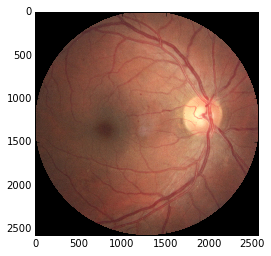

In [4]:
(img, mask, x, y, r) = circularcrop(img)
plt.imshow(img)

##Method Description
Our input image is an array of $N$ numeric values in the $[min, max]$ interval. The output is a corrected array of the $N$ updated numeric values. _Multiple channel images are processed independently on each channel with the same method._

We will perform a color balance on this data where we have saturated a percentage $s_1%$ of the pixels on the left side of the histogram, and a percentage $s_2%$ of pixels on the right side; for example, $s_1=0$ and $s_2=3$ means that this balance will saturate no pixels at the beginning and will saturate at most $N\frac{3}{100}$ at the end of the histogram. We can't ensure that exactly $N\frac{s_1+s_2}{100}$ pixels are saturated because the pixel value distribution is discrete.



##Sorting

The saturation extrema $V_{min}$ and $V_{max}$ can be seen as quantiles of the pixel values distribution, e.g. first and 99th centiles for a 2% saturation.

Thus, an easy way to compute $V_{min}$ and $V_{max}$ is to sort the pixel values, and pick the quantiles from the sorted array. This algorithm would be described as follow:

* <b>sort the pixel values</b> The original values must be kept for further transformation by the bounded affine function, so the $N$ pixels must first be copied before sorting.
* <b>pick the quantiles</b> From the sorted pixels with a saturation level $s=s_1+s_2$ in $[0, 100]$, we want to saturate $N \frac{s}{100}$ pixels, so $V_{min}$ and $V_{max}$ are taken from the sorted array at positions $N\frac{s_1} {100}$ and $N(1 - \frac{s_2}{100}) - 1$.
* <b>saturate the pixels</b> According to the previous definitions of $V_{min}$ and $V_{max}$, the number of pixels with values lower than $V_{min}$ or higher than $V_{max}$ is at most $N\frac{s}{100}$. The pixels (in the original unsorted array) are updated to $V_{min}$ (resp. $V_{max}$) if their value is lower than $V_{min}$ (resp. higher than $V_{max}$).
* <b>affine transform</b> The image is scaled to $[min, max]$ with a transformation of the pixel values by the function $f$ such that $f(x) = (x - V_{min})\frac{max - min}{V_{max} - V_{min}} + min$.


In [5]:
img_r = img[:,:,0]
h, bins = np.histogram(img_r,bins=256,range=(0,255))
h[0] -= np.sum(1 - mask) # compensate for the borders
histo = np.cumsum(h)

Let's see how this looks like

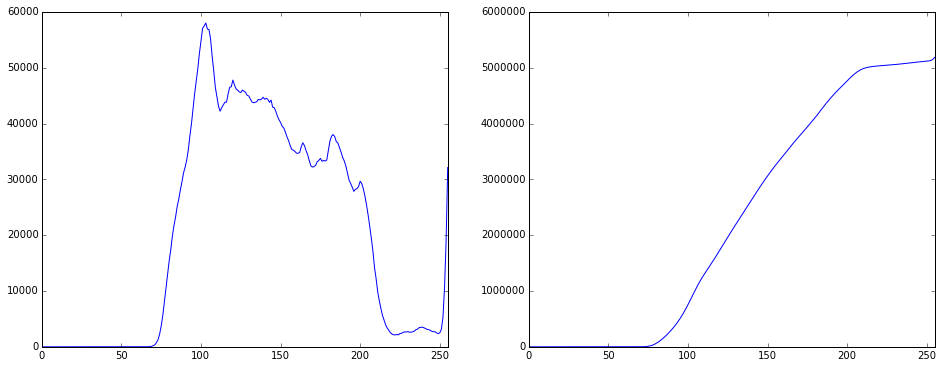

In [6]:
f, (ax1, ax2) = plt.subplots(1,2)
f.set_size_inches((16,6))
ax1.set_xlim(left=0, right=255)
ax1.plot(h)
ax2.set_xlim(left=0, right=255)
ax2.plot(histo)

In [7]:
s1 = 1.
s2 = 1.
N = img_r.shape[0] * img_r.shape[1]

Search for the saturation extremas pixel values ignoring required percentage of dim pixels

In [8]:
vmin = np.argmin(histo <= N * s1 / 100)

In [9]:
vmax = np.argmax(histo > N * (1. - s2 / 100))
vmax = 255 if vmax== 0 else vmax
print vmin, vmax

81 255


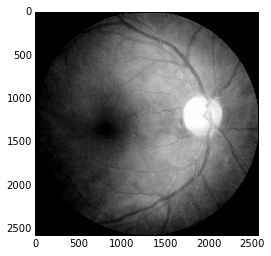

In [10]:
scale = 255. / (vmax - vmin)
img_r = np.maximum(img_r, vmin) # saturate values smaller than the minimal
img_r = np.minimum(img_r, vmax) # saturater values larger than vmax
img_r = (img_r - vmin) * scale
img_r = np.reshape(img_r, img[:,:,0].shape)
img_r = np.array(img_r, dtype=np.uint8)
plt.imshow(img_r, cmap='gray')

Let's see how adjusted histogram looks like

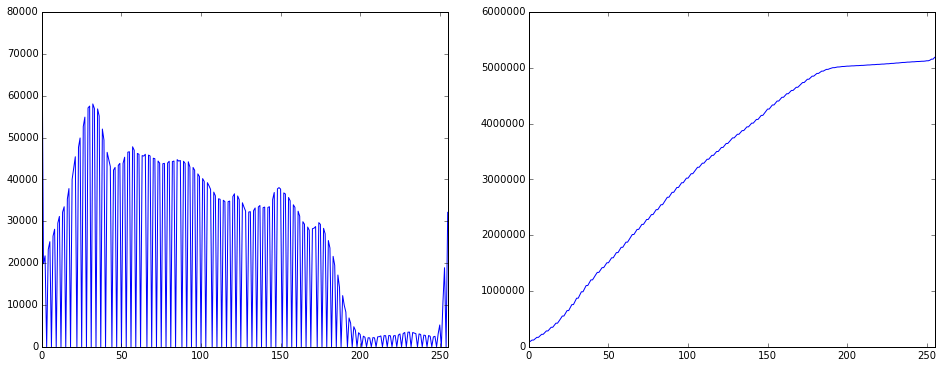

In [11]:
h1, bins = np.histogram(img_r,bins=256,range=(0,255))
h1[0] -= np.sum(1 - mask) # compensate for the borders
histo1 = np.cumsum(h1)

f, (ax1, ax2) = plt.subplots(1,2)
f.set_size_inches((16,6))
ax1.set_xlim(left=0, right=255)
ax1.plot(h1)
ax2.set_xlim(left=0, right=255)
ax2.plot(histo1)

Now combine everything together

In [12]:
def cbalance(img, mask, s1, s2):
    
    h, bins = np.histogram(img,bins=256,range=(0,255))
    h[0] -= np.sum(1 - mask) # compensate for the borders
    histo = np.cumsum(h)    
    N = img.shape[0] * img.shape[1]    
    
    vmin = np.argmin(histo <= N * s1 / 100)
    vmax = np.argmax(histo > N * (1. - s2 / 100))
    vmax = 255 if vmax== 0 else vmax

    scale = 255. / (vmax - vmin)

    img = np.maximum(img, vmin) # saturate values smaller than the minimal
    img = np.minimum(img, vmax) # saturater values larger than vmax
    img = (img - vmin) * scale
    img = np.array(img, dtype=np.uint8)
    
    return img

def colorbalance(img, mask, s1, s2):
    ared = cbalance(np.array(img[:,:,0]), mask, s1, s2)
    agreen = cbalance(np.array(img[:,:,1]), mask, s1, s2)
    ablue = cbalance(np.array(img[:,:,2]), mask, s1, s2)
    
    return np.dstack((ared, agreen, ablue ))

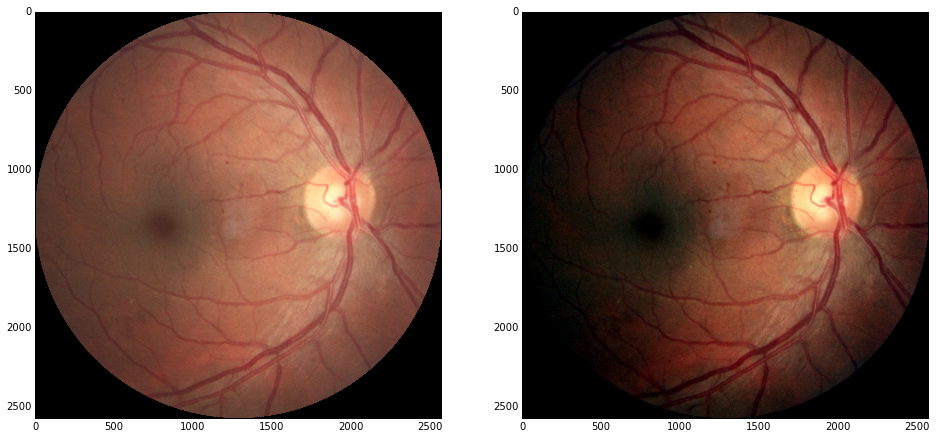

In [13]:
img = np.array(imgOrig)
(img, mask, x, y, r) = circularcrop(img)

img1 = colorbalance(img, mask, 1, 1)

f, (ax1, ax2) = plt.subplots(1,2)
f.set_size_inches(16,8)
ax1.imshow(img)
ax2.imshow(img1)


And let's play with a different image

In [14]:
baseFolder = '/Users/vtymchenko/Dropbox/Shared/Retina'
imgFile = 'crop/20677_left.jpeg'
filename = os.path.join(baseFolder, imgFile)
img = skimage.io.imread(filename)

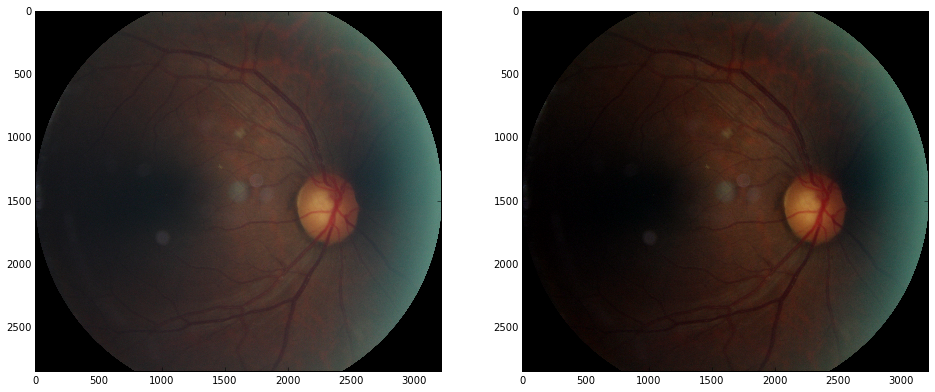

In [15]:
(img, mask, x, y, r) = circularcrop(img)
img1 = colorbalance(img, mask, 1, 1)

f, (ax1, ax2) = plt.subplots(1,2)
f.set_size_inches(16,8)
ax1.imshow(img)
ax2.imshow(img1)